<a href="https://colab.research.google.com/github/piglesias98/VC/blob/master/Cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de librerías necesarias

In [0]:
!pip install tensorflow


In [0]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
 from tensorflow import keras


In [0]:
print(keras.__version__)

2.2.4-tf


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as np_utils

Using TensorFlow backend.


Importamos los modelos y capas que se van a usar

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [0]:
from keras.optimizers import SGD
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import applications
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array


Añadimos los datos del drive

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Funciones auxiliares

Lectura y modificación del conjunto de imágenes

In [0]:
def cargarImagenes():
  #Cargamos Cifar100.
  #Cada imagen tiene tamaño (32,32,3)
  
  (x_train, y_train),(x_test, y_test)=cifar100.load_data(label_mode='fine')
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  #Normalizamos
  x_train=x_train/255
  x_test=x_test/255
  
  #Nos quedamos con las imágenes de 25 de las clases
  train_idx = np.isin(y_train, np.arange(25))
  train_idx = np.reshape(train_idx, -1)
  x_train = x_train[train_idx]
  y_train = y_train[train_idx]

  test_idx = np.isin(y_test, np.arange(25))
  test_idx = np.reshape(test_idx, -1)
  x_test = x_test[test_idx]
  y_test = y_test[test_idx]

  #Transformamos los vectores de clases en matrices
  #Cada componente se convierte en un vector de ceros
  #con un uno en la componente correspondiente a la imagen
  # --> necesario para la clasificación multiclase en keras

  y_train = np_utils.to_categorical(y_train, 25)
  y_test = np_utils.to_categorical(y_test, 25)

  return x_train, y_train, x_test, y_test

**Obtener el accuracy en el conjunto de test**

La función devuelve el accuracy de un modelo, definido como el porcentaje de etiquetas bien predichas frente al total de etiquetas.

Como parámetros es necesario pasarle el vecto de etiquetas verdaderas y el vector de etiquetas predichas en el formato de keras

--> matrices donde cada etiqueta ocupa una fila, con un 1 en la posicion de la clase a la que pertenece y un 0 en las demás.

In [0]:
def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis=1)
  preds = np.argmax(preds, axis=1)
  
  accuracy = sum(labels==preds)/len(labels)

  return accuracy

**Gráficas**

Gráficas para la evolución de pérdida y el accuracy en train y en validación durante el entrenamiento

Esta función pinta dos gráficas:

1. Evolución de la función de pérdida en el conjunto de train y en el de validación
2. Evolución del accuracy en el conjunto de train y el de validación

Necesario --> pasarle como parámetro el historial del entrenamiento del modelo (lo que devuelven fit() y fit_generator()

In [0]:

def mostrarEvolucion(hist):
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Taining loss', 'Validation loss'])
  plt.show()
  acc = hist.history['acc']
  val_acc = hist.history['val_acc']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

# Definición de modelos BaseNet

Modelo base_net original, tal y como viene definido en el guion de la práctica

In [0]:
def base_net():
  modelo = Sequential()
  modelo.add(Conv2D(6, kernel_size=(5,5),
                    activation='relu',
                    input_shape=(32,32,3)))
  modelo.add(MaxPooling2D(pool_size=(2,2)))
  modelo.add(Conv2D(16, kernel_size=(5,5),
             activation='relu'))
  modelo.add(MaxPooling2D(pool_size=(2,2)))
  modelo.add(Flatten())
  modelo.add(Dense(50, activation='relu'))
  modelo.add(Dense(25, activation='softmax'))

  return modelo

MEJORA CAPAS DE CONVOLUCIÓN --> Añadimos más capas de convolución, éstas con un filtro más pequeño, con el fin de hacer la red más profunda

In [0]:
def base_net_convolucion():
  modelo = Sequential()
  modelo.add(Conv2D(32,
                    kernel_size=(3,3),
                    activation='relu',
                    input_shape=(32,32,3)))

  modelo.add(Conv2D(32,
                    kernel_size=(3,3),
                    activation='relu'))
  modelo.add(MaxPooling2D(pool_size=(2,2)))

  modelo.add(Conv2D(64,
                    kernel_size=(3,3),
                    activation='relu'))

  modelo.add(Conv2D(64,
                    kernel_size=(3,3),
                    activation='relu'))
  modelo.add(MaxPooling2D(pool_size=(2,2)))

  modelo.add(Conv2D(128,
                    kernel_size=(3,3),
                    activation='relu'))
  modelo.add(MaxPooling2D(pool_size=(2,2)))

  modelo.add(Flatten())
  modelo.add(Dense(256, activation='relu'))
  modelo.add(Dense(25, activation='softmax'))

  return modelo

MEJORA CAPAS BATCH NORMALIZATION --> Añadimos capasde batch normalization tras las capas convolucionales y lineales

In [0]:
def base_net_batch_normalization():
  modelo = Sequential()
  modelo.add(Conv2D(32,
                    kernel_size=(3,3),
                    activation='relu',
                    input_shape=(32,32,3)))
  modelo.add(BatchNormalization())

  modelo.add(Conv2D(32,
                    kernel_size=(3,3),
                    activation='relu'))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))

  modelo.add(Conv2D(64,
                    kernel_size=(3,3),
                    activation='relu'))
  modelo.add(BatchNormalization())

  modelo.add(Conv2D(64,
                    kernel_size=(3,3),
                    activation='relu'))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))

  modelo.add(Conv2D(128,
                    kernel_size=(3,3),
                    activation='relu'))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))

  modelo.add(Flatten())
  modelo.add(Dense(256, activation='relu'))
  modelo.add(Dense(25, activation='softmax'))

  return modelo


EXPERIMENTACION CAPAS BATCH NORMALIZATION DESPÚES DE ACTIVACIÓN--> Añadimos capas de batch normalization tras las activaciones, para esto hemos "dividido" lo que antes eran capas de convolución + activación en dos capas separadas, para en medio añadir una capa de batch normalization extra

In [0]:
def base_net_batch_normalization_despues():
  modelo = Sequential()
  modelo.add(Conv2D(32,
                    kernel_size=(3,3),
                    input_shape=(32,32,3)))
  modelo.add(BatchNormalization())
  modelo.add(Activation('relu'))
  modelo.add(BatchNormalization())
  modelo.add(Conv2D(32,
                    kernel_size=(3,3)))
  modelo.add(BatchNormalization())
  modelo.add(Activation('relu'))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))

  modelo.add(Conv2D(64,
                    kernel_size=(3,3)))
  modelo.add(BatchNormalization())
  modelo.add(Activation('relu'))
  modelo.add(BatchNormalization())

  modelo.add(Conv2D(64,
                    kernel_size=(3,3)))
  modelo.add(BatchNormalization())
  modelo.add(Activation('relu'))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))

  modelo.add(Conv2D(128,
                    kernel_size=(3,3)))
  modelo.add(BatchNormalization())
  modelo.add(Activation('relu'))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))

  modelo.add(Flatten())
  modelo.add(Dense(256, activation='relu'))
  modelo.add(BatchNormalization())
  modelo.add(Dense(25, activation='softmax'))

  return modelo

MEJORA CAPA DROPOUT --> Añadimos capas dropout después de las capas maxpooling de 0.25 con el fin de prevenir el overfitting

In [0]:
def base_net_2():
  modelo = Sequential()
  modelo.add(Conv2D(32,
                    kernel_size=(3,3),
                    activation='relu',
                    input_shape=(32,32,3)))
  modelo.add(BatchNormalization())

  modelo.add(Conv2D(32,
                    kernel_size=(3,3),
                    activation='relu'))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))
  modelo.add(Dropout(0.25))

  modelo.add(Conv2D(64,
                    kernel_size=(3,3),
                    activation='relu'))
  modelo.add(BatchNormalization())

  modelo.add(Conv2D(64,
                    kernel_size=(3,3),
                    activation='relu'))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))
  modelo.add(Dropout(0.25))

  modelo.add(Conv2D(128,
                    kernel_size=(3,3),
                    activation='relu'))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))
  modelo.add(Dropout(0.25))

  modelo.add(Flatten())
  modelo.add(Dense(256, activation='relu'))
  modelo.add(Dense(25, activation='softmax'))

  return modelo


# Entrenamiento


Compilación y entrenamiento básico con fit() 

In [0]:
def entrenamiento_1(modelo, batch_size, epocas):
  #Optimizador
  opt = SGD(lr=0.01, momentum = 0.9, decay=1e-6, nesterov=True )
  #Compilación
  modelo.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
  weights = modelo.get_weights()

  x_train, y_train, x_test, y_test = cargarImagenes()
  histograma = modelo.fit(x_train,
                          y_train,
                          batch_size=batch_size,
                          epochs = epocas,
                          verbose=1,
                          validation_data=(x_test,y_test))
  score = modelo.evaluate(x_test, y_test, verbose=0)
  print('Test loss', score[0])
  print('Test accuracy', score[1])
  return histograma, weights


MEJORA ENTRENAMIENTO NORMALIZACIÓN --> preprocesamos los datos normalizándolos con los parámetros featurewise_std_normalization y feature_wise_center para conseguir media 0 y desviación estándar 1. Además separamos el 10% para los datos de validación

In [0]:
def entrenamiento_normalizacion(modelo, batch_size, epocas):
  #Optimizador
  opt = SGD(lr=0.01, momentum = 0.9, decay=1e-6, nesterov=True )
  #Compilación
  modelo.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
  weights = modelo.get_weights()

  x_train, y_train, x_test, y_test = cargarImagenes()
  #Data augmentation
  #Dividimos el conjunto de entrenamiento en un 90% entrenamiento y 10% validación
  datagen = ImageDataGenerator(featurewise_center = True,
                              featurewise_std_normalization = True,
                               validation_split = 0.1
                               )
  #Como hemos normalizado con media 0 y varianza 1, es necesario usar fit()
  #sobre el generador creado
  datagen.fit(x_train)
  #Debemos normalizar el conjunto test con los mismos parámetros que hemos
  #usado para train
  datagen.standardize(x_test)

  h = modelo.fit_generator(
                    generator = datagen.flow(
                                      x_train,
                                      y_train,
                                      batch_size = batch_size,
                                      subset='training'),
                    steps_per_epoch = len(x_train)*0.9/batch_size,
                    epochs=epocas,
                    validation_data = datagen.flow(
                                      x_train,
                                      y_train,
                                      batch_size=batch_size,
                                      subset='validation'),
                       validation_steps = len(x_train)*0.1/32
                       )
  score = modelo.evaluate(x_test, y_test, verbose=0)
  print('Test loss', score[0])
  print('Test accuracy', score[1])
  return h, weights


MEJORA DATA AUGMENTATION --> Utilizamos la clase ImageDataGenerator ahora para realizar transformaciones en las imágenes, tales como traslación, rotación, cambios de escala, cizallamiento y volteados horizontales o verticales.

In [0]:
def entrenamiento_data_augmentation(modelo, batch_size, epocas):
  #Optimizador
  opt = SGD(lr=0.01, momentum = 0.9, decay=1e-6, nesterov=True )
  #Compilación
  modelo.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
  weights = modelo.get_weights()

  x_train, y_train, x_test, y_test = cargarImagenes()
  #Data augmentation
  #Dividimos el conjunto de entrenamiento en un 90% entrenamiento y 10% validación
  datagen = ImageDataGenerator(featurewise_center = True,
                               featurewise_std_normalization = True,
                               validation_split = 0.1,
                               zoom_range=0.15,
                               horizontal_flip=True,
                               fill_mode="nearest",
                               width_shift_range=0.2,
                               height_shift_range=0.2
                               )
  #Como hemos normalizado con media 0 y varianza 1, es necesario usar fit()
  #sobre el generador creado
  datagen.fit(x_train)
  #Debemos normalizar el conjunto test con los mismos parámetros que hemos
  #usado para train
  datagen.standardize(x_test)

  h = modelo.fit_generator(
                    generator = datagen.flow(
                                      x_train,
                                      y_train,
                                      batch_size = batch_size,
                                      subset='training'),
                    steps_per_epoch = len(x_train)*0.9/batch_size,
                    epochs=epocas,
                    validation_data = datagen.flow(
                                      x_train,
                                      y_train,
                                      batch_size=batch_size,
                                      subset='validation'),
                       validation_steps = len(x_train)*0.1/32
                       )
  score = modelo.evaluate(x_test, y_test, verbose=0)
  print('Test loss', score[0])
  print('Test accuracy', score[1])
  return h, weights

MEJORA EARLY STOPPING --> Añadimos un callback para utilzar EarlyStopping
Queremos minimizar el loss y maximizar la accuracy, quedándonos con los mejores pesos y dándole una "paciencia" de 5 épocas

In [0]:
def entrenamiento_early_stopping(modelo, batch_size, epocas):
  #Optimizador
  opt = SGD(lr=0.01, momentum = 0.9, decay=1e-6, nesterov=True )
  #Compilación
  modelo.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
  weights = modelo.get_weights()

  x_train, y_train, x_test, y_test = cargarImagenes()
  #Data augmentation
  #Dividimos el conjunto de entrenamiento en un 90% entrenamiento y 10% validación
  datagen = ImageDataGenerator(featurewise_center = True,
                               featurewise_std_normalization = True,
                               validation_split = 0.1,
                               zoom_range=0.15,
                               horizontal_flip=True,
                               fill_mode="nearest",
                               width_shift_range=0.2,
                               height_shift_range=0.2
                               )
  #Como hemos normalizado con media 0 y varianza 1, es necesario usar fit()
  #sobre el generador creado
  datagen.fit(x_train)
  #Debemos normalizar el conjunto test con los mismos parámetros que hemos
  #usado para train
  datagen.standardize(x_test)

  h = modelo.fit_generator(
                    generator = datagen.flow(
                                      x_train,
                                      y_train,
                                      batch_size = batch_size,
                                      subset='training'),
                    steps_per_epoch = len(x_train)*0.9/batch_size,
                    epochs=epocas,
                    validation_data = datagen.flow(
                                      x_train,
                                      y_train,
                                      batch_size=batch_size,
                                      subset='validation'),
                    validation_steps = len(x_train)*0.1/32,
                    callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights = True, verbose=1), ModelCheckpoint(monitor = 'val_acc', filepath = 'mejores.hdf5', mode = 'max', save_best_only=True, ) ]
                       )
  score = modelo.evaluate(x_test, y_test, verbose=0)
  print('Test loss', score[0])
  print('Test accuracy', score[1])
  return h, weights

Una vez tenemos el modelo base, antes de entrenar guardamos los pasos aleatorios con los que empieza la red para poder reestablecerlos después y poder comparar los resultados entre no usar mejoras y sí usar

# Ejercicios

## Ejercicio 1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                20050     
_________________________________________________________________
dense_8 (Dense)              (None, 25)               

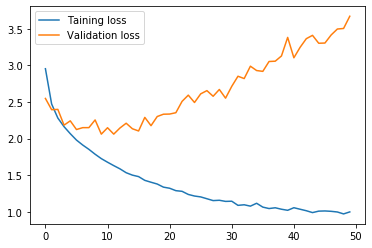

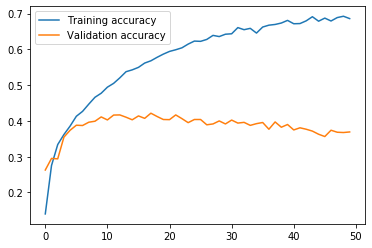

In [0]:
print("--------------Ejercicio 1-----------------")
mi_modelo_1 = base_net()
mi_modelo_1.summary()
histograma, weights = entrenamiento_1(mi_modelo_1, 32, 50)
mostrarEvolucion(histograma)
mi_modelo_1.set_weights(weights)
input("Pulse Enter para continuar")


## Ejercicio 2


--------------Ejercicio 2-----------------
>>>>>>>>>>>>>>>>>Mejora: Red más profunda 




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
______________________________

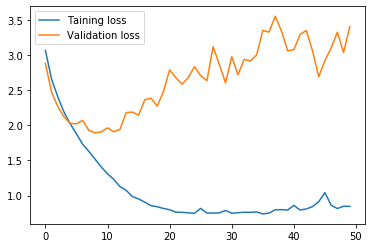

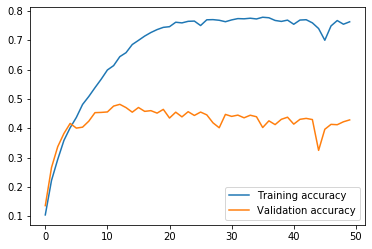

Pulse Enter para continuar


''

In [0]:
print("--------------Ejercicio 2-----------------")
print(">>>>>>>>>>>>>>>>>Mejora: Red más profunda ")
mi_modelo_2 = base_net_convolucion()
mi_modelo_2.summary()
histograma, weights = entrenamiento_1(mi_modelo_2, 32, 50)
mostrarEvolucion(histograma)
mi_modelo_2.set_weights(weights)
input("Pulse Enter para continuar")

>>>>>>>>>>>>>>>>>Mejora: BatchNormalization 


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_n

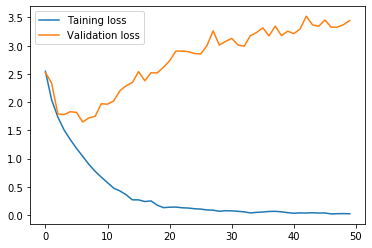

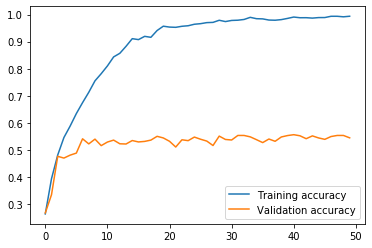

Pulse Enter para continuar


''

In [0]:
print(">>>>>>>>>>>>>>>>>Mejora: BatchNormalization ")
mi_modelo_3 = base_net_batch_normalization()
mi_modelo_3.summary()
histograma, weights = entrenamiento_1(mi_modelo_3, 32, 50)
mostrarEvolucion(histograma)
mi_modelo_3.set_weights(weights)
input("Pulse Enter para continuar")

>>>>>>>>>>>>>>>>>Mejora: BatchNormalization tras capas activación
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 32)        128       
______________________________________________________

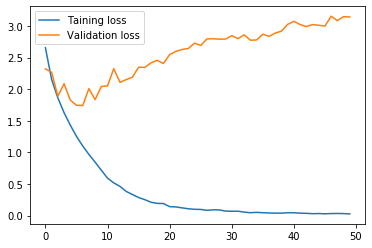

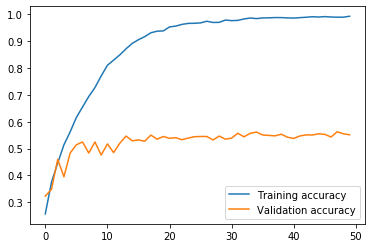

Pulse Enter para continuar


''

In [0]:
print(">>>>>>>>>>>>>>>>>Mejora: BatchNormalization tras capas activación")
mi_modelo_4 = base_net_batch_normalization_despues()
mi_modelo_4.summary()
histograma, weights = entrenamiento_1(mi_modelo_4, 32, 50)
mostrarEvolucion(histograma)
mi_modelo_4.set_weights(weights)
input("Pulse Enter para continuar")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_____

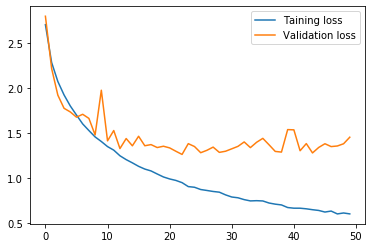

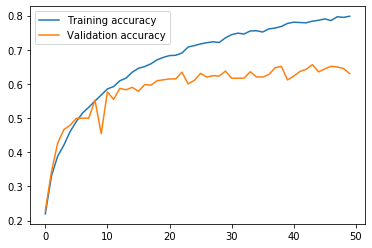

In [0]:
print(">>>>>>>>>>>>>>>>>Mejora: Dropout ")
mi_modelo_2 = base_net_2()
mi_modelo_2.summary()
histograma, weights = entrenamiento_1(mi_modelo_2, 32, 50)
mostrarEvolucion(histograma)
mi_modelo_2.set_weights(weights)
input("Pulse Enter para continuar")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 64)       

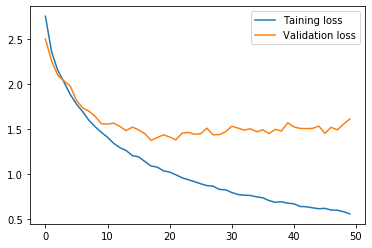

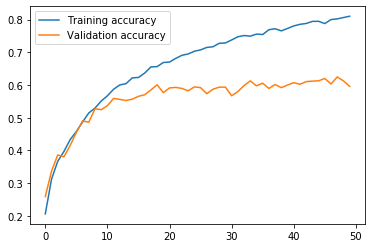

In [0]:
print(">>>>>>>>>>>>>>>>>Mejora: Normalización ")
mi_modelo_2 = base_net_2()
mi_modelo_2.summary()
histograma, weights = entrenamiento_normalizacion(mi_modelo_2, 32, 50)
mostrarEvolucion(histograma)
mi_modelo_2.set_weights(weights)
input("Pulse Enter para continuar")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 64)       

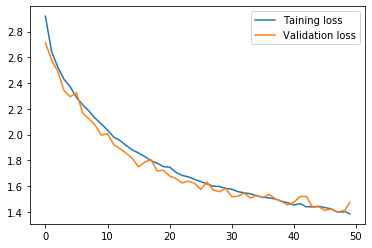

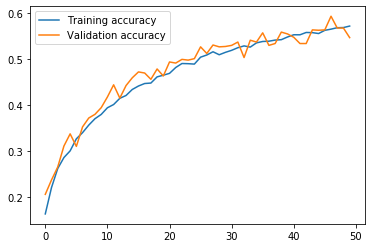

In [0]:
print(">>>>>>>>>>>>>>>>>Mejora: Data Augmentation ")
mi_modelo_3 = base_net_2()
mi_modelo_3.summary()
histograma, weights = entrenamiento_data_augmentation(mi_modelo_2, 32,50)
mostrarEvolucion(histograma)
mi_modelo_3.set_weights(weights)
input("Pulse Enter para continuar")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)       

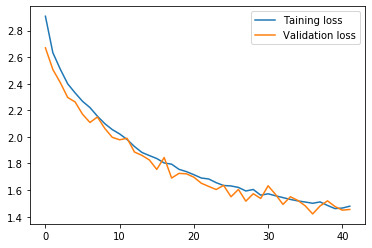

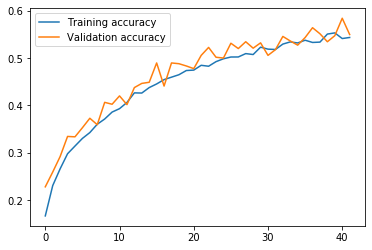

In [0]:
print(">>>>>>>>>>>>>>>>>Mejora: Early Stopping ")
mi_modelo_4 = base_net_2()
mi_modelo_4.summary()
histograma, weights = entrenamiento_early_stopping(mi_modelo_4, 32, 50)
mostrarEvolucion(histograma)
mi_modelo_4.set_weights(weights)
input("Pulse Enter para continuar")